# Zonally Averaged Temperature  and Salinity Bias
 

In [1]:
%matplotlib inline

import pandas as pd
import intake
catalog = intake.cat.access_nri
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
from dask.distributed import Client, progress

import sys, os

        os.chdir(os.path.join(os.getcwd(), "cosima-recipes/ACCESS-OM2-GMD-Paper-Figs"))
        sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

Available exptdata keys:  ['1deg', '025deg', '01deg']


In [2]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    #plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [3]:
# use common start and end dates for all runs
tstart = exptdata.clim_tstart
tend = exptdata.clim_tend

In [4]:
client = Client("tcp://10.6.43.39:8786")
client

Client Scheduler: tcp://127.0.0.1:38095 Dashboard: /proxy/8787/status,Cluster Workers: 8 Cores: 48 Memory: 202.48 GB


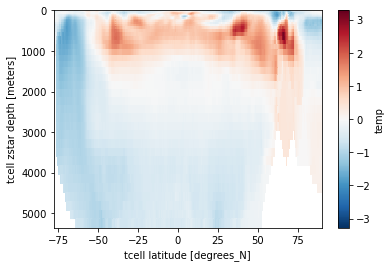

In [13]:
ekey='1deg'
expt = exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']

cat_subset = catalog[expt]
var_search = cat_subset.search(variable='temp')
darray = var_search.to_dask()
darray = darray['temp']
if offset:# shift time axis of darray by 'offset'
    darray = darray.assign_coords(time = darray.time - xr.coding.cftime_offsets.to_offset(offset))
temp_10 = darray.sel(time=slice(tstart,tend)).mean('time')

ds = xr.open_mfdataset('/g/data/ik11/observations/woa13/10_KDS50/woa13_ts_??_mom10.nc')
ds = ds.rename({'GRID_Y_T': 'yt_ocean', 'GRID_X_T': 'xt_ocean', 'ZT': 'st_ocean'})
ds['st_ocean'] = temp_10.st_ocean
ds['xt_ocean'] = temp_10.xt_ocean
ds['yt_ocean'] = temp_10.yt_ocean
temp_WOA13_10 = ds.temp.mean('time')

temp_anom_10 = temp_10 - temp_WOA13_10 - 273.15
zonal_temp_anom_10 = temp_anom_10.mean('xt_ocean')
zonal_temp_anom_10.load()

zonal_temp_anom_10.plot(yincrease=False)

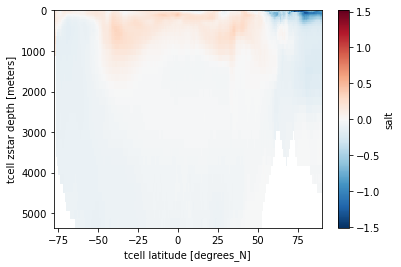

In [14]:
cat_subset = catalog[expt]
var_search = cat_subset.search(variable='salt')
darray = var_search.to_dask()
darray = darray['salt']
if offset:# shift time axis of darray by 'offset'
    darray = darray.assign_coords(time = darray.time - xr.coding.cftime_offsets.to_offset(offset))
salt_10 = darray.sel(time=slice(tstart,tend)).mean('time')
salt_WOA13_10 = ds.salt.mean('time')

salt_anom_10 = salt_10 - salt_WOA13_10
zonal_salt_anom_10 = salt_anom_10.mean('xt_ocean')
zonal_salt_anom_10.load()

zonal_salt_anom_10.plot(yincrease=False)

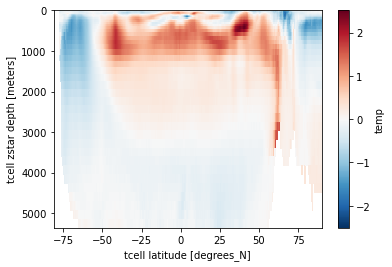

In [15]:
ekey='025deg'
expt = exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']

cat_subset = catalog[expt]
var_search = cat_subset.search(variable='temp')
darray = var_search.to_dask()
darray = darray['temp']
if offset:# shift time axis of darray by 'offset'
    darray = darray.assign_coords(time = darray.time - xr.coding.cftime_offsets.to_offset(offset))
temp_025 = darray.sel(time=slice(tstart,tend)).mean('time')

ds = xr.open_mfdataset('/g/data/ik11/observations/woa13/025_KDS50/woa13_ts_??_mom025.nc')
ds = ds.rename({'GRID_Y_T': 'yt_ocean', 'GRID_X_T': 'xt_ocean', 'ZT': 'st_ocean'})
ds['st_ocean'] = temp_025.st_ocean
ds['xt_ocean'] = temp_025.xt_ocean
ds['yt_ocean'] = temp_025.yt_ocean
temp_WOA13_025 = ds.temp.mean('time')

temp_anom_025 = temp_025 - temp_WOA13_025 - 273.15
zonal_temp_anom_025 = temp_anom_025.mean('xt_ocean')
zonal_temp_anom_025.load()

zonal_temp_anom_025.plot(yincrease=False)

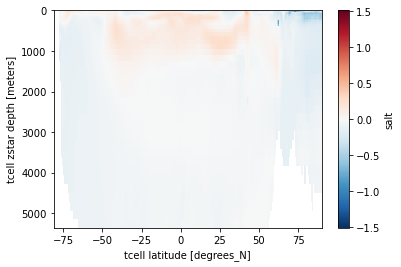

In [16]:
cat_subset = catalog[expt]
var_search = cat_subset.search(variable='salt')
darray = var_search.to_dask()
darray = darray['salt']
if offset:# shift time axis of darray by 'offset'
    darray = darray.assign_coords(time = darray.time - xr.coding.cftime_offsets.to_offset(offset))
salt_025 = darray.sel(time=slice(tstart,tend)).mean('time')
salt_WOA13_025 = ds.salt.mean('time')

salt_anom_025 = salt_025 - salt_WOA13_025
zonal_salt_anom_025 = salt_anom_025.mean('xt_ocean')
zonal_salt_anom_025.load()

zonal_salt_anom_025.plot(yincrease=False)

## At 01deg this calculation is difficult

Here we specify a chunking strategy that seems to worth with 8 workers and 192Gb memory. This might be able to be further optimised. Note that a key part of this memory strategy is to load `temp_01` as soon as it is calculated...

In [7]:
%%time
ekey='01deg'
expt = exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']

chunks={'st_ocean':None, 'xt_ocean': 120, 'yt_ocean': 120}

cat_subset = catalog[expt]
var_search = cat_subset.search(variable='temp')
darray = var_search.to_dask()
darray = darray['temp']
if offset:# shift time axis of darray by 'offset'
    darray = darray.assign_coords(time = darray.time - xr.coding.cftime_offsets.to_offset(offset))
temp_01 = darray.sel(time=slice(tstart,tend)).mean('time').load()  

CPU times: user 44min 55s, sys: 2min 7s, total: 47min 2s
Wall time: 1h 7min 9s


In [8]:
%%time
woa_chunks={'ZT':None, 'GRID_X_T': 120, 'GRID_Y_T': 120}
ds = xr.open_mfdataset('/g/data/ik11/observations/woa13/01/woa13_ts_??_mom01.nc',chunks=woa_chunks)
ds = ds.rename({'GRID_Y_T': 'yt_ocean', 'GRID_X_T': 'xt_ocean', 'ZT': 'st_ocean'})
ds['st_ocean'] = temp_01.st_ocean
ds['xt_ocean'] = temp_01.xt_ocean
ds['yt_ocean'] = temp_01.yt_ocean
temp_WOA13_01 = ds.temp.mean('time').load()

CPU times: user 1min 56s, sys: 36.3 s, total: 2min 32s
Wall time: 6min 5s


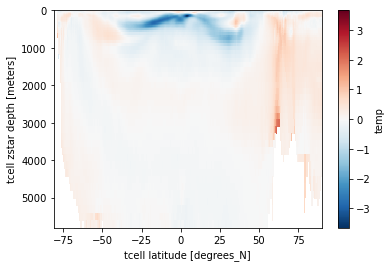

In [9]:
%%time
temp_anom_01 = temp_01 - temp_WOA13_01 - 273.15
zonal_temp_anom_01 = temp_anom_01.mean('xt_ocean')
zonal_temp_anom_01.load()

zonal_temp_anom_01.plot(yincrease=False)

In [10]:
%%time
cat_subset = catalog[expt]
var_search = cat_subset.search(variable='salt')
darray = var_search.to_dask()
darray = darray['salt']
if offset:# shift time axis of darray by 'offset'
    darray = darray.assign_coords(time = darray.time - xr.coding.cftime_offsets.to_offset(offset))
salt_01 = darray.sel(time=slice(tstart,tend)).mean('time').load()

CPU times: user 55min 48s, sys: 2min 34s, total: 58min 22s
Wall time: 1h 19min 5s


In [11]:
%%time
salt_WOA13_01 = ds.salt.mean('time').load()

CPU times: user 3min 48s, sys: 1min 4s, total: 4min 53s
Wall time: 11min


CPU times: user 8.45 s, sys: 55.6 s, total: 1min 4s
Wall time: 1min


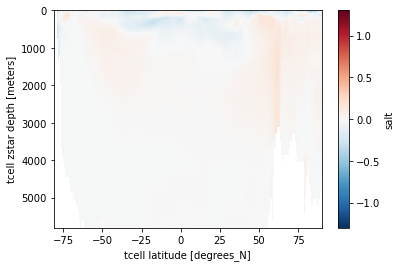

In [12]:
%%time
salt_anom_01 = salt_01 - salt_WOA13_01
zonal_salt_anom_01 = salt_anom_01.mean('xt_ocean')
zonal_salt_anom_01.load()

zonal_salt_anom_01.plot(yincrease=False)

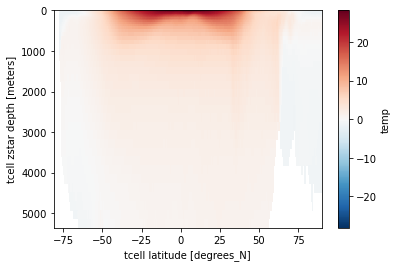

In [17]:
mask = temp_025.copy()
mask = mask/mask                 ## This seems pretty dodgy to me, but it works!!
temp_WOA13_025 = temp_WOA13_025*mask
zonal_temp_WOA13_025 = temp_WOA13_025.mean('xt_ocean')
zonal_temp_WOA13_025.load()

zonal_temp_WOA13_025.plot(yincrease=False)

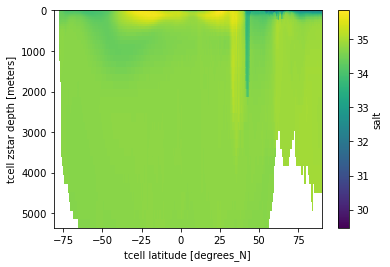

In [18]:
mask = salt_025.copy()
mask = mask/mask                 ## This seems pretty dodgy to me, but it works!!
salt_WOA13_025 = salt_WOA13_025*mask
zonal_salt_WOA13_025 = salt_WOA13_025.mean('xt_ocean')
zonal_salt_WOA13_025.load()

zonal_salt_WOA13_025.plot(yincrease=False)

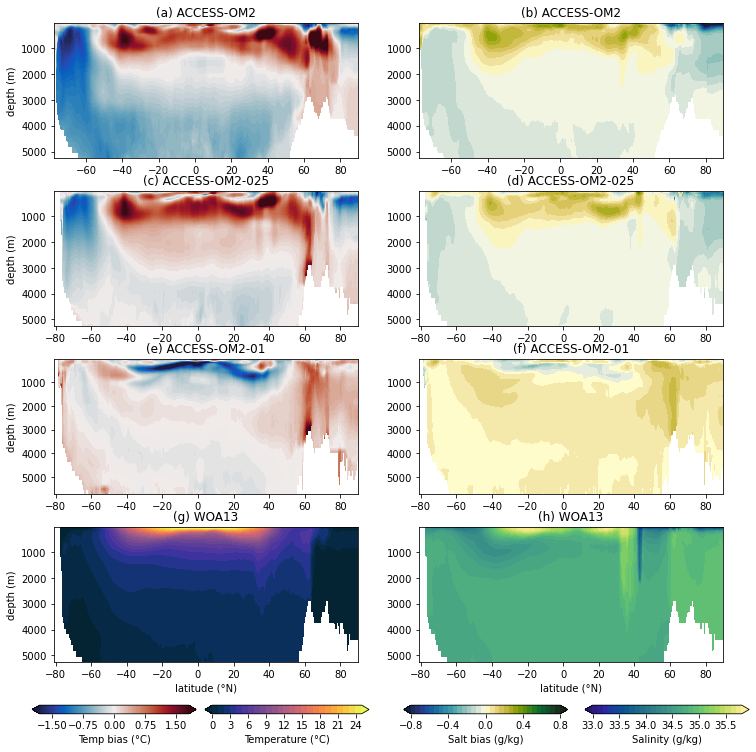

In [19]:
plt.figure(figsize=(12,12))
clev=np.arange(-1.8,1.81,0.05)
clev2=np.arange(-0.8,0.81,0.05)
    
plt.subplot(421)
p1=zonal_temp_anom_10.plot.contourf(cmap=cm.cm.balance,levels=clev,yincrease=False,add_colorbar=False)
plt.xlabel('')
plt.ylabel('depth (m)')
plt.title('(a) ACCESS-OM2')

plt.subplot(422)
s1=zonal_salt_anom_10.plot.contourf(cmap=cm.cm.delta,levels=clev2,yincrease=False,add_colorbar=False)
plt.xlabel('')
plt.ylabel('')
plt.title('(b) ACCESS-OM2')

plt.subplot(423)
p2=zonal_temp_anom_025.plot.contourf(cmap=cm.cm.balance,levels=clev,yincrease=False,add_colorbar=False)
plt.xlabel('')
plt.ylabel('depth (m)')
plt.title('(c) ACCESS-OM2-025')

plt.subplot(424)
s2=zonal_salt_anom_025.plot.contourf(cmap=cm.cm.delta,levels=clev2,yincrease=False,add_colorbar=False)
plt.xlabel('')
plt.ylabel('')
plt.title('(d) ACCESS-OM2-025')

plt.subplot(425)
p3=zonal_temp_anom_01.plot.contourf(cmap=cm.cm.balance,levels=clev,yincrease=False,add_colorbar=False)
plt.xlabel('')
plt.ylabel('depth (m)')
plt.title('(e) ACCESS-OM2-01')

plt.subplot(426)
s3=zonal_salt_anom_01.plot.contourf(cmap=cm.cm.delta,levels=clev2,yincrease=False,add_colorbar=False)
plt.xlabel('')
plt.ylabel('')
plt.title('(f) ACCESS-OM2-01')

plt.subplot(427)
p4=zonal_temp_WOA13_025.plot.contourf(cmap=cm.cm.thermal,levels=np.arange(0,26,1),yincrease=False,add_colorbar=False)
plt.xlabel('latitude (°N)')
plt.ylabel('depth (m)')
plt.title('(g) WOA13')

plt.subplot(428)
s4=zonal_salt_WOA13_025.plot.contourf(cmap=cm.cm.haline,levels=np.arange(33,35.81,0.1),yincrease=False,add_colorbar=False)
plt.xlabel('latitude (°N)')
plt.ylabel('')
plt.title('(h) WOA13')

plt.subplots_adjust(bottom=0.14,hspace=0.24)

ax1 = plt.axes([0.1,0.08,0.19,0.01])
cb1 = plt.colorbar(p1,cax=ax1,orientation='horizontal',ticks=[-1.5, -0.75, 0, 0.75, 1.5])
#ax1.xaxis.set_label_position("top")
cb1.set_label('Temp bias (°C)')

ax2 = plt.axes([0.3,0.08,0.19,0.01])
cb2 = plt.colorbar(p4,cax=ax2,orientation='horizontal')
#ax1.xaxis.set_label_position("top")
cb2.set_label('Temperature (°C)')

ax3 = plt.axes([0.53,0.08,0.19,0.01])
cb3 = plt.colorbar(s1,cax=ax3,orientation='horizontal',ticks=[-0.8, -0.4, 0, 0.4, 0.8])
#ax1.xaxis.set_label_position("top")
cb3.set_label('Salt bias (g/kg)')

ax4 = plt.axes([0.74,0.08,0.19,0.01])
cb4 = plt.colorbar(s4,cax=ax4,orientation='horizontal',ticks=[33, 33.5, 34, 34.5, 35, 35.5])
#ax1.xaxis.set_label_position("top")
cb4.set_label('Salinity (g/kg)')

savefigure('zonal_temp_salt_bias')